# Manuscript code - The balance between intrinsic and ecological fitnessdefines new regimes in eco-evolutionary population dynamics

Authors: 
Rowan J. Barker-Clarke, Jason M. Gray, Maximilian A. R. Strobl, Jeff Maltas, Dagim
Shiferaw Tadele, Michael Hinczewski, and Jacob G. Scott.

### Wright-Fisher model of mutation and random genetic drift

A Wright-Fisher model has a fixed population size N and discrete non-overlapping generations. Each generation, each individual has a random number of offspring whose mean is proportional to the individual's fitness. Each generation, mutation may occur.

#### Setup

In [2]:
import numpy as np
import statistics as stat
import pandas as pd
import seaborn as sns
import random
from itertools import *
try:
    import itertools.izip as zip
except ImportError:
    import itertools

/usr/local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Fokker-Planck solution

In [495]:
def fx(x,awm,amw,s):
    if awm==0:
        return(s*x)
    f = (-x + mu*np.log(1-x)+mu*np.log(x)-x*amw/awm + np.log(1+x*awm)*(amw + (1+s+amw)*awm)/(awm**2))
    #fx = (-a21*(a12+a21)*x + (a12+a21+a12*a21+a21*s)*np.log(1+ a21+ a21*x))/(a21**2)
        
    return(f)
    
def potential(x,N, mu, a12,a21,s):
    phi = np.log(x*(1-x)/2*N)-2*N*fx(x,a12,a21,s)
    return(phi)


Make population dynamic model

Basic parameters

In [4]:
pop_size = 1000
seq_length = 1
alphabet = ['0','1']
base_haplotype = "0"


Setup a population of sequences

Store this as a lightweight Dictionary that maps a string to a count. All the sequences together will have count N.


In [5]:
pop = {}
pop["0"] = 100
pop["1"] = 900

Add mutation

Mutations occur each generation in each individual in every basepair.



In [6]:
mutation_rate = 0.0005 # per gen per individual per site

Walk through population and mutate basepairs.
Use Poisson splitting to speed this up (you may be familiar with Poisson splitting from its use in the Gillespie algorithm).

In naive scenario A: take each element and check for each if event occurs. For example, 100 elements, each with 1% chance. This requires 100 random numbers.
In Poisson splitting scenario B: Draw a Poisson random number for the number of events that occur and distribute them randomly. In the above example, this will most likely involve 1 random number draw to see how many events and then a few more draws to see which elements are hit.
First off, we need to get random number of total mutations


In [7]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)
#Here we use Numpy's Poisson random number.

get_mutation_count()

1

In [8]:
pop.keys()

dict_keys(['0', '1'])

In [9]:

[x/float(pop_size) for x in pop.values()]


[0.1, 0.9]

In [10]:
def get_random_haplotype():
    haplotypes = list(pop.keys())
    frequencies = [x/float(pop_size) for x in pop.values()]
    total = sum(frequencies)
    frequencies = [x / total for x in frequencies]
    return np.random.choice(haplotypes, p=frequencies)

get_random_haplotype()

'1'

Here, we take a supplied haplotype and mutate a site at random.


In [11]:
def get_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype

get_mutant("0")


'1'

Putting things together, in a single mutation event, we grab a random haplotype from the population, mutate it, decrement its count, and then check if the mutant already exists in the population. If it does, increment this mutant haplotype; if it doesn't create a new haplotype of count 1.


In [12]:
def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = get_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1
mutation_event()
pop

{'0': 101, '1': 899}

To create all the mutations that occur in a single generation, we draw the total count of mutations and then iteratively add mutation events.


In [13]:
def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()
mutation_step()
pop

{'0': 101, '1': 899}

## Genetic drift and selection

Selection and fitness are influenced by the game and payoff matrix

In [14]:
awm = x = 0.1
amw = y =  0.1
s=0


In [15]:
def get_fitness(awm, amw, s, frequencies):
    payoff=[[1, 1+awm], [1+s+amw, 1+s]]
    x = frequencies
    f = np.dot(payoff,x)
    fitness = {'0':f[0], '1':f[1]}
    return fitness

In [16]:
pop = {'0':500, '1':500}
haplotypes = list(pop.keys())
frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]


In [17]:
def get_offspring_counts(s,x,y):
    haplotypes = list(pop.keys())
    frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]
    fitness = get_fitness(x,y,s,frequencies)
    fitnesses = [fitness[haplotype] for haplotype in haplotypes]
    weights = [x * y for x,y in zip(frequencies, fitnesses)]
    total = sum(weights)
    weights = [x / total for x in weights]
    #print(weights)
    return list(np.random.multinomial(pop_size, weights))
#Here we use Numpy's multinomial random sample.

get_offspring_counts(s,x,y)


[498, 502]


We then need to assign this new list of haplotype counts to the pop dictionary. To save memory and computation, if a haplotype goes to 0, we remove it entirely from the pop dictionary.


In [18]:
def offspring_step(s,x,y):
    haplotypes = list(pop.keys())
    counts = get_offspring_counts(s,x,y)
    for (haplotype, count) in zip(haplotypes, counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            pop[haplotype] = 0
offspring_step(s,x,y)
pop

{'0': 497, '1': 503}

Combine and iterate

Each generation is simply a mutation step where a random number of mutations are thrown down, and an offspring step where haplotype counts are updated.


In [19]:
def time_step(s,x,y):
    mutation_step()
    offspring_step(s,x,y)

Can iterate this over a number of generations.


In [20]:
pop = {'0':100,'1':100}
generations = 100
def simulate(s,x,y):
    for i in range(generations):
        time_step(s,x,y)
simulate(s,x,y)
pop

{'0': 557, '1': 443}

Record

We want to keep a record of past population frequencies to understand dynamics through time. At each step in the simulation, we append to a history object.


In [21]:
pop0 = {'0':500,'1':500}
history = []
generations = 1000


def simulate(s,x,y):
    history = []
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step(s,x,y)
        clone_pop = dict(pop)
        history.append(clone_pop)
    return(history)



### Comparing simulated distribution to Fokker-Planck
Function and potential 

#### Examples for Figures
Fig 4 - Main text 

In [487]:
fig4 = (0.1,0.14,0.16,0.01)
example = fig4

0.1 0.14 0.16
s0.1_amw0.14_awm0.16_mu0.01_theoretical.png


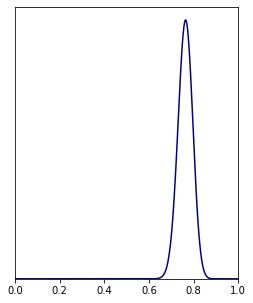

In [489]:
# Theoretical distribution
vals = 1000 # number of points to evaluate function over

p = np.linspace(0.001,0.999,vals)

# Function values
N=1000
mu=example[3]
s=0

#Random coefficients
#a12_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]
#a21_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]

fp_sol = []
fp_mean=[]
fp_pot=[]

for s,a12,a21,mu in [example]:
    print(s,a12,a21)
    q = potential(p,N, mu, a12,a21,s)
    #mean_pot = np.mean(q)
    #print(q)# - mean_pot)
    c = np.exp(-(q)) #-mean_pot))
    #print(c)
    #print(sum(c))
    fp_pot.append(-q)
    fp_sol.append(c)
    fp_mean.append(np.dot(p,c)/sum(c))
    
fname = f's{s}_amw{round(a12,4)}_awm{round(a21,4)}_mu{mu}_theoretical.png'
print(fname)

plt.plot(p, fp_sol[0]/max(fp_sol[0]), color = 'darkblue')
plt.xlim(0,1)
plt.ylim(0,)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(4, 5)
plt.savefig(fname,dpi=200)

In [491]:
# Simulation
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []

mutation_rate = mu = example[3]
generations = gens = 500
reps = 100

#a12_list = [round(random.uniform(-0.3, 0.3),4) for i in range(1000)]
#a21_list = [round(random.uniform(-0.3, 0.3),4) for i in range(1000)]


history = []
history1 =[]

for i in range(1,reps+1):
    #Initialise population
    init = np.random.randint(0,N)
    pop = {'0':init,'1':N-init}

    #Simulate with parameters
    a = simulate(example[0],example[1],example[2])
    history1.append([ii['0'] for ii in a])
    history.append(a)

histories1.append(flatten(history1))
histories.append(history)

In [492]:
histories_fig4 = histories

(0.0, 1000.0)

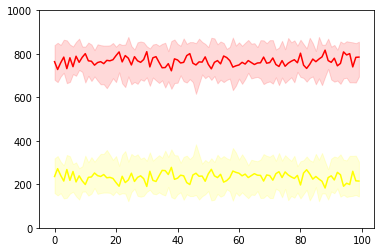

In [493]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
all0=[]
all1=[]
gens = 500

for si in range(0,reps):
    vals0 = []
    vals1=[]
    for t in range(200,500):
        #print(si, t)
        sli = histories_fig4[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    all1.append(vals1)
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

#plot distribution
ax = sns.lineplot(x=[i for i in range(0,reps)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,reps)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,reps)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,reps)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))



### Fig S2

In [462]:
example1 = (0.05,0.1,0.0901)
example=example1

Theoretical Distribution

s0.1_amw0.14_awm0.16_mu0.01_theoretical.png


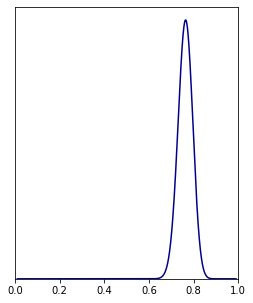

In [474]:
vals = 1000 # number of points to evaluate function over

p = np.linspace(0.01,0.99,vals)

# Function values
N=1000
mu=0.01
s=0

#Random coefficients
#a12_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]
#a21_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]

fp_sol = []
fp_mean=[]
fp_pot=[]

for s,a12,a21 in [example]:
    q = potential(p,N, mu, a12,a21,s)
    #mean_pot = np.mean(q)
    #print(q)# - mean_pot)
    c = np.exp(-(q)) #-mean_pot))
    #print(c)
    #print(sum(c))
    fp_pot.append(-q)
    fp_sol.append(c)
    fp_mean.append(np.dot(p,c)/sum(c))
    
fname = f's{s}_amw{round(a12,4)}_awm{round(a21,4)}_mu{mu}_theoretical.png'
print(fname)

plt.plot(p, fp_sol[0]/max(fp_sol[0]), color = 'darkblue')
plt.xlim(0,1)
plt.ylim(0,)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(4, 5)
plt.savefig(fname,dpi=200)

Simulation distribution

In [475]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []

mutation_rate = mu = 0.001
generations = gens = 500
reps = 100

#a12_list = [round(random.uniform(-0.3, 0.3),4) for i in range(1000)]
#a21_list = [round(random.uniform(-0.3, 0.3),4) for i in range(1000)]


history = []
history1 =[]

for i in range(1,reps+1):
    #Initialise population
    init = np.random.randint(0,N)
    pop = {'0':init,'1':N-init}

    #Simulate with parameters
    a = simulate(example[0],example[1],example[2])
    history1.append([ii['0'] for ii in a])
    history.append(a)

histories1.append(flatten(history1))
histories.append(history)

In [456]:
histories_example1 = histories

(0.0, 1000.0)

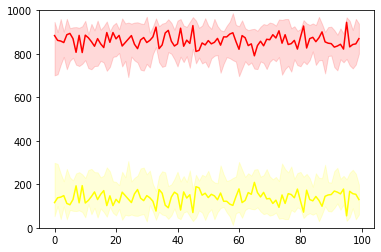

In [473]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
all0=[]
all1=[]
gens = 500

for si in range(0,reps):
    vals0 = []
    vals1=[]
    for t in range(200,500):
        #print(si, t)
        sli = histories_fig4[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    all1.append(vals1)
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

#plot distribution
ax = sns.lineplot(x=[i for i in range(0,reps)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,reps)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,reps)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,reps)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))



s0.05_amw0.1_awm0.0901_mu0.001_N1000_sims.png


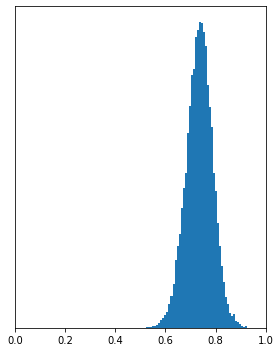

In [458]:

# Use all 2nd genotype (e.g. wildtype) values
subset = list(flatten(all1))

plt.hist(x=[i/N for i in subset],bins=50)
#graph.set(xlim=(0, 1))

N= sum(pop.values())
mu= mutation_rate
name=f's{s}_amw{round(a12,4)}_awm{round(a21,4)}_mu{mu}_N{N}_sims.png'

#plt.plot(p, fp_sol[0]/max(fp_sol[0]), color = 'darkblue')
plt.xlim(0,1)
plt.ylabel('')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)

print(name)

fname =name
plt.gcf().set_size_inches(4, 5)
plt.tight_layout()
plt.savefig(fname,dpi=200)

Example 2

In [408]:
example2 = (0.05,0.14,0.16)
example = example2

s0.05_amw0.14_awm0.16_mu0.01_theoretical.png


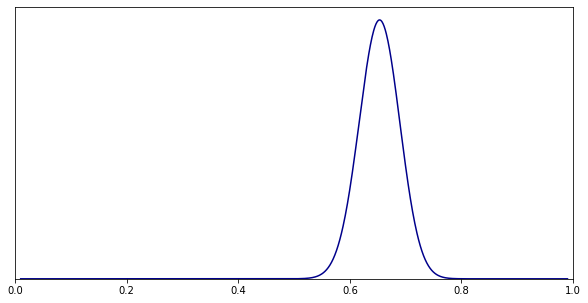

In [409]:
vals = 1000 # number of points to evaluate function over

p = np.linspace(0.01,0.99,vals)

# Function values
N=1000
mu=0.01
s=example[0]

#Random coefficients
#a12_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]
#a21_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]

fp_sol = []
fp_mean=[]
fp_pot=[]

for s,a12,a21 in [example]:
    q = potential(p,N, mu, a12,a21,s)

    c = np.exp(-(q))

    fp_pot.append(-q)
    fp_sol.append(c)
    fp_mean.append(np.dot(p,c)/sum(c))
    
fname = f's{s}_amw{round(a12,4)}_awm{round(a21,4)}_mu{mu}_theoretical.png'
print(fname)
plt.plot(p, fp_sol[0]/sum(fp_sol[0]), color = 'darkblue')
plt.xlim(0,1)
plt.ylim(0)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig(fname,dpi=200)

In [410]:
#default population
pop = {'0':500,'1':500}

outcomes = []
histories = []
histories1=[]

s=example[0]
N=1000
mu=0.01
mutation_rate = mu =0.01
generations = gens = 500
reps = 100

for i in range(1,reps+1):
    #Initialise population
    init = np.random.randint(0,N)
    pop = {'0':init,'1':N-init}

    #Simulate with parameters
    a = simulate(-example[0],example[2], example[1])
    
    history1.append([ii['0'] for ii in a])
    history.append(a)

histories1.append(flatten(history1))
histories.append(history)

In [405]:
histories_example2 = histories

(0.0, 1000.0)

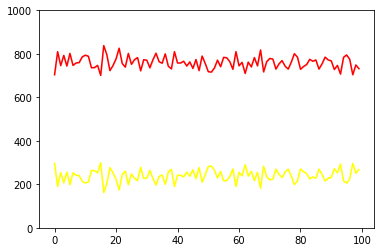

In [494]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 500
all0=[]

for si in range(0,reps):
    vals0 = []
    vals1=[]
    for t in range(400,401):
        #print(si, t)
        sli = histories[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
        all0.append(vals0)
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,reps)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,reps)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,reps)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,reps)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

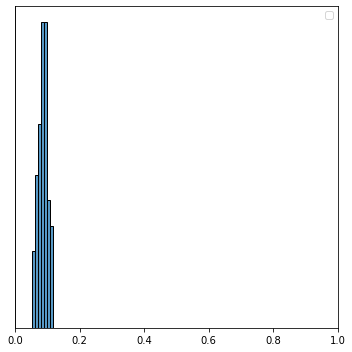

In [391]:
subset = mode0
graph =sns.histplot(x=[(i/N) for i in subset])
#graph.axhline(0, c="black")
graph.axvline(0,  c="black")
graph.set(xlim=(0, 1))

#graph.axhline(-s, c="black", linestyle='--')
#graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
fname = f's{s}_amw{round(a12,4)}_awm{round(a12,4)}_mu{mu}_N{N}_sims.png'
plt.xlim(0,1)
plt.ylabel('')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(5, 5)
plt.tight_layout()
plt.savefig(name)

#### Example 3

In [505]:
#(s,awm,amw,mu)
example3 = (0.05,-0.05,-0.151,0.01)
example =example3

s0.05_amw-0.05_awm-0.151_mu0.01_theoretical.png


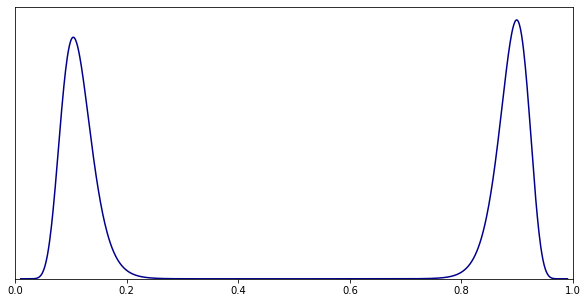

In [506]:
vals = 1000 # number of points to evaluate function over

p = np.linspace(0.01,0.99,vals)

# Function values
N=1000
mu=example[3]
s=example[0]

#Random coefficients
#a12_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]
#a21_list = [round(random.uniform(-0.1, 0.1),3) for i in range(20)]

fp_sol = []
fp_mean=[]
fp_pot=[]

for s,a12,a21,mu in [example]:
    q = potential(p,N, mu, a12,a21,s)

    c = np.exp(-(q))

    fp_pot.append(-q)
    fp_sol.append(c)
    fp_mean.append(np.dot(p,c)/sum(c))
    
fname = f's{s}_amw{round(a12,4)}_awm{round(a21,4)}_mu{mu}_theoretical.png'
print(fname)
plt.plot(p, fp_sol[0]/sum(fp_sol[0]), color = 'darkblue')
plt.xlim(0,1)
plt.ylim(0)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig(fname,dpi=200)

In [507]:
#Simulations
#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
mutation_rate = mu = example[3]
generations = gens = 500
reps = 500

for jj in [0.1]:
    outcome = []
    history = []
    history1 =[]
    print(jj)
    for i in range(1,reps+1):
        init = np.random.randint(0,N)
        pop = {'0':init,'1':N-init}

        a = simulate(example[0], example[1], example[2])
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)

0.1


In [301]:
histories_example3 = histories

(0.0, 1000.0)

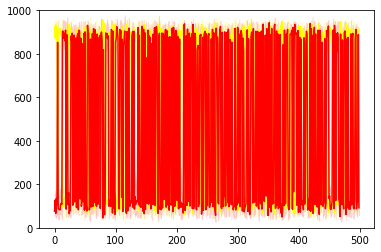

In [302]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 500
all0=[]
for si in range(0,reps):
    vals0 = []
    vals1=[]
    for t in range(200,500):
        #print(si, t)
        sli = histories_example3[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
        all0.append(vals0)
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,reps)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,reps)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,reps)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,reps)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

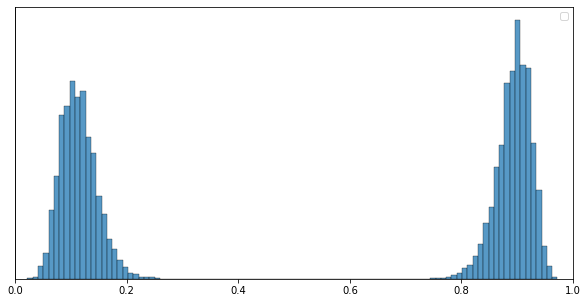

In [309]:
(s,b,c) = example3
subset = list(flatten(all0))
graph =sns.histplot(x=[(i/N) for i in subset], bins=100)
#graph.axhline(0, c="black")
graph.axvline(0,  c="black")
graph.set(xlim=(0, 1))

#graph.axhline(-s, c="black", linestyle='--')
#graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
name = 's'+str(s)+'N'+str(N)+'mu'+str(mu)+'awm'+str(round(b,4))+'amw'+str(round(c,4))+'mu'+str(mu)+'.png'
plt.xlim(0,1)
plt.ylabel('')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig(name)

#### Example 4

In [508]:
example4 = (-0.05, 0.1, 0.05,0.01)
example = example4

In [509]:
#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
mutation_rate = mu = example[3]
generations = gens = 500
reps = 500

for jj in [0.1]:
    outcome = []
    history = []
    history1 =[]
    print(jj)
    for i in range(1,reps+1):
        init = np.random.randint(0,N)
        pop = {'0':init,'1':N-init}
        #amw = jj
        #a = simulate(s,awm,amw)
        a = simulate(example[0], example[1], example[2])
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)

0.1


In [510]:
histories_example4 = histories

(0.0, 1000.0)

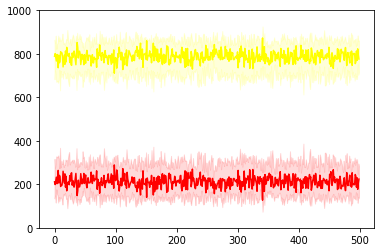

In [511]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 500
all0=[]
for si in range(0,reps):
    vals0 = []
    vals1=[]
    for t in range(300,500):
        #print(si, t)
        sli = histories_example4[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
        all0.append(vals0)
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,reps)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,reps)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,reps)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,reps)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

FileNotFoundError: [Errno 2] No such file or directory: '~/Dropbox/ecoepistasis/s-0.05N1000mu0.01awm0.1amw0.05mu0.01.png'

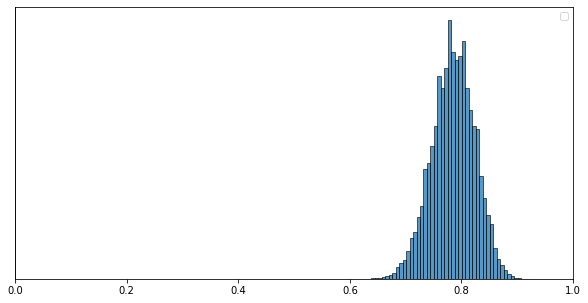

In [512]:
(s,b,c,mu) = example4
subset = list(flatten(all0))
graph =sns.histplot(x=[(i/N) for i in subset], bins=50)
#graph.axhline(0, c="black")
graph.axvline(0,  c="black")
graph.set(xlim=(0, 1))

#graph.axhline(-s, c="black", linestyle='--')
#graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
name = 's'+str(s)+'N'+str(N)+'mu'+str(mu)+'awm'+str(round(b,4))+'amw'+str(round(c,4))+'mu'+str(mu)+'.png'
plt.xlim(0,1)
plt.ylabel('')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,      # ticks along the top edge are off
    labelleft=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig('~/Dropbox/ecoepistasis/'+name)